# Imports

In [73]:
import os
from PIL import Image, ImageOps
import pandas as pd
import numpy as np
# import seaborn as sns
from tqdm import tqdm
import cv2
import imutils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
import matplotlib.cm as cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

# Simple Detection Model

# Data Loading

In [44]:
def display_image(image_path):
    img = Image.open(image_path)
    img.show()

yes_path = './data/yes'
no_path = "./data/no"

In [45]:
def create_dataframe(yes_path, no_path):
    # Initialize an empty list to store the data
    data = []

    # Process 'yes' images
    for image in os.listdir(yes_path):
        data.append({
            "image_path": os.path.join(yes_path, image),
            "tumor_present": "yes"
        })

    # Process 'no' images
    for image in os.listdir(no_path):
        data.append({
            "image_path": os.path.join(no_path, image),
            "tumor_present": "no"
        })

    # Create a DataFrame
    df = pd.DataFrame(data)

    return df

## Train, Test, Validation Splits

In [46]:
def create_train_test_val_splits(df, test_size=0.2, val_size=0.1):

    # First, split into training + validation and test sets
    train_val_df, test_df = train_test_split(df, test_size=test_size, random_state=42)

    # Adjust val_size to compensate for the initial split
    adjusted_val_size = val_size / (1 - test_size)

    # Then, split the training + validation set into training and validation sets
    train_df, val_df = train_test_split(train_val_df, test_size=adjusted_val_size, random_state=42)

    return train_df, val_df, test_df

In [47]:
total_data = create_dataframe(yes_path, no_path)
total_data = total_data.sample(frac=1).reset_index(drop=True)

In [48]:
# Shuffle and split the data
train_data, val_data, test_data = create_train_test_val_splits(total_data)

# Display the sizes of each set
print(f"Training Set: {len(train_data)}")
print(f"Validation Set: {len(val_data)}")
print(f"Test Set: {len(test_data)}")

print(train_data.head())

Training Set: 2100
Validation Set: 300
Test Set: 600
                image_path tumor_present
921   ./data/yes/y1494.jpg           yes
339    ./data/yes/y342.jpg           yes
1984  ./data/yes/y1126.jpg           yes
2439  ./data/no/no1179.jpg            no
259   ./data/no/no1285.jpg            no


# Make images the same size and normalize

In [49]:
# Global counter for images that are excluded
excluded_images_count = 0
all_images = 0

def preprocess_image(image_path, target_size):
    global excluded_images_count
    global all_images
    all_images += 1

    try:
        img = Image.open(image_path)
        img = ImageOps.fit(img, target_size, Image.Resampling.LANCZOS)  # Resizing with LANCZOS
        img = np.array(img)
        if img.shape != (target_size[0], target_size[1], 3):  # Check if image has three color channels
            excluded_images_count += 1
            return None
        img = img / 255.0  # Normalize pixel values
        return img
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        excluded_images_count += 1
        return None

def encode_label(label):
    return 1 if label == 'yes' else 0

def prepare_dataset(df, target_size=(224, 224)):
    images = df['image_path'].apply(lambda x: preprocess_image(x, target_size)).dropna()
    labels = df['tumor_present'][images.index].apply(encode_label)  # Align labels with images
    return np.array(images.tolist()), np.array(labels)

In [50]:
def show_sample_images(data, preprocess_func, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        img = preprocess_func(data.iloc[i]['image_path'], (224, 224))
        plt.imshow(img)
        plt.title(data.iloc[i]['tumor_present'])
        plt.axis("off")

# Prepare Data and Visualize some samples

Total images excluded: 109
all images : 3005


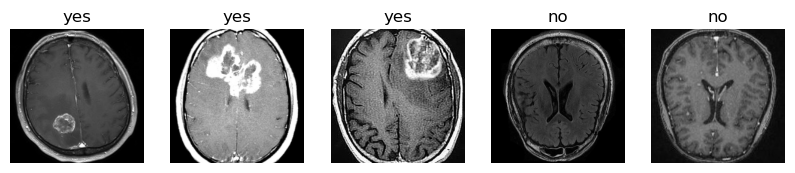

In [51]:
X_train, y_train = prepare_dataset(train_data)
X_val, y_val = prepare_dataset(val_data)
X_test, y_test = prepare_dataset(test_data)

show_sample_images(train_data, preprocess_image)


print(f"Total images excluded: {excluded_images_count}")
print(f"all images : {all_images}")

# Custom Model

In [52]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu, input_shape=(224, 224, 3)),  # Adjusted input shape
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu, name="final_conv_layer"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()
# Model Compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Training using Validation Data
history = model.fit(X_train, y_train, batch_size=35, epochs=2, verbose=1, validation_data=(X_val, y_val))


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 final_conv_layer (Conv2D)   (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 56, 56, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 100352)           

## Analysis

Text(0.5, 1.0, 'Loss over Epochs')

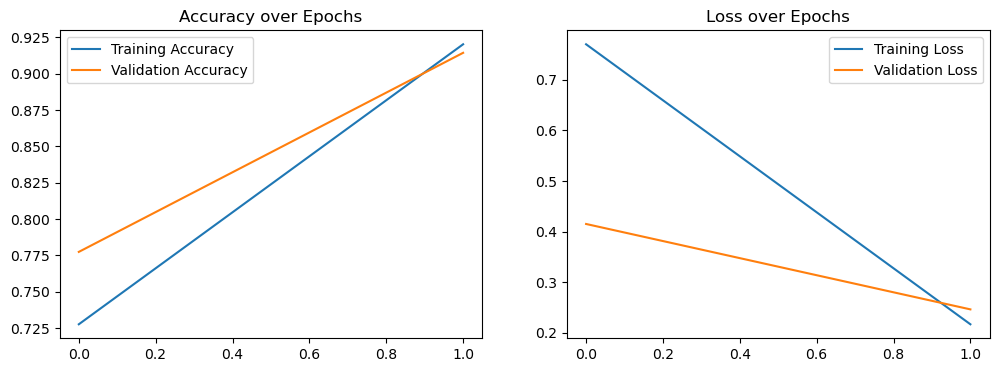

In [53]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

### Heat Maps

In [54]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    gradcam = Gradcam(model, model_modifier=None, clone=False)
    cam = gradcam(
        lambda output: output[pred_index] if pred_index else output,
        img_array,
        penultimate_layer=-1,
    )
    heatmap = normalize(cam)
    return heatmap

In [55]:
def show_images_with_heatmaps(image_paths, model, preprocess_func, last_conv_layer_name):
    plt.figure(figsize=(10, 10))

    for i, image_path in enumerate(image_paths):
        # Original image
        original_img = preprocess_func(image_path, (224, 224))
        ax = plt.subplot(5, 2, 2 * i + 1)
        plt.imshow(original_img)
        plt.title(f"Original - {image_path.split('/')[-1]}")
        plt.axis('off')

        img_array = np.array([original_img])
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        ax = plt.subplot(5, 2, 2 * i + 2)
        plt.imshow(original_img)
        plt.imshow(heatmap.squeeze(), cmap='jet', alpha=0.5)  
        plt.title("Heatmap")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

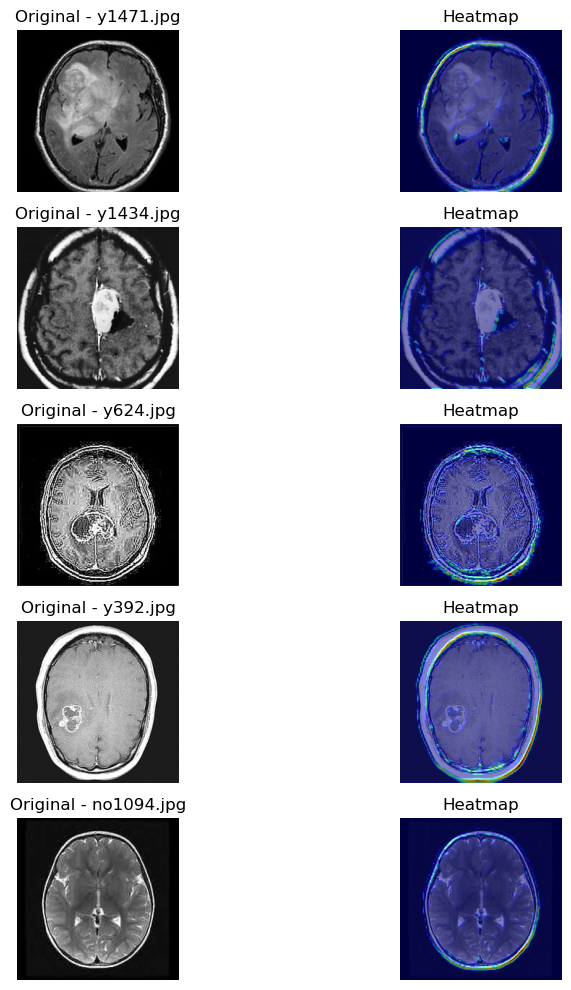

In [56]:
image_paths = [
    './data/yes/y1471.jpg',
    './data/yes/y1434.jpg',
    './data/yes/y624.jpg',
    './data/yes/y392.jpg',
    './data/no/no1094.jpg'
]

show_images_with_heatmaps(image_paths, model, preprocess_image, 'conv2d_4')

In [57]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

19/19 [==============================] - 4s 212ms/step - loss: 0.2008 - accuracy: 0.9276
Test Loss: 0.20081672072410583
Test Accuracy: 0.9275861978530884


### Confusion Matrix

In [58]:
def confusion_mat(true_classes, predicted_classes, tumor_types):
    cm = confusion_matrix(true_classes, predicted_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=tumor_types, yticklabels=tumor_types)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [82]:
test_predictions = np.round(model.predict(X_test).flatten())
binary_tumor_types = ['yes', 'no']

19/19 [==============================] - 4s 178ms/step


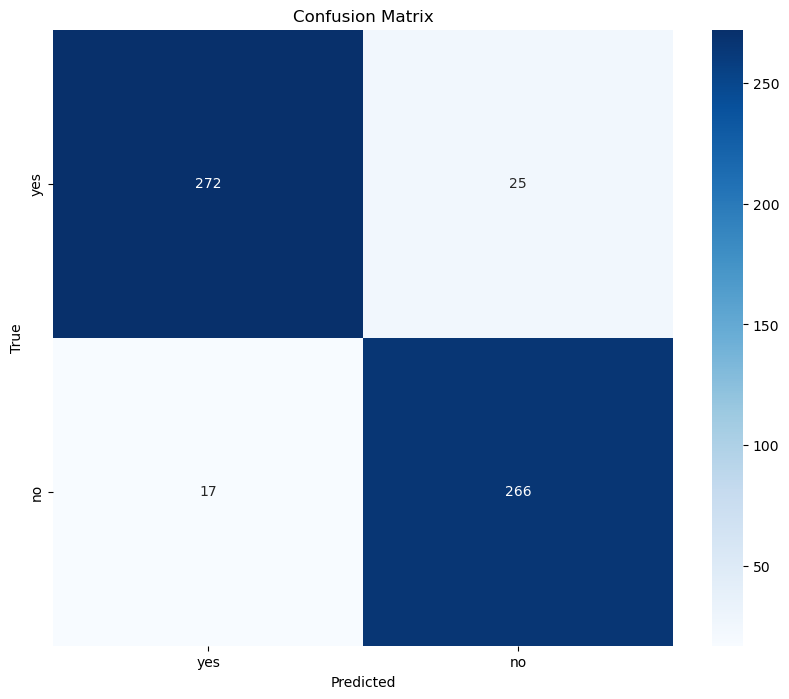

In [68]:
confusion_mat(y_test, test_predictions, binary_tumor_types)

# VGG16 Model

In [69]:
# Load VGG16 pre-trained on ImageNet data
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze the base_model
base_model.trainable = False

# Add custom layers on top of VGG16 base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# This is the model we will train
vgg_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

vgg_model.summary()

# Train the model
vgg_history = model.fit(X_train, y_train, batch_size=35, epochs=1, verbose=1, validation_data=(X_val, y_val))

# Use Grad-CAM
# show_images_with_heatmaps(image_paths, model, preprocess_image, 'block5_conv3')


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [71]:
vgg_test_loss, vgg_test_accuracy = vgg_model.evaluate(X_test, y_test)

print(f"VGG16 Model - Test Loss: {vgg_test_loss}, Test Accuracy: {vgg_test_accuracy}")

19/19 [==============================] - 87s 5s/step - loss: 0.8160 - accuracy: 0.5121
VGG16 Model - Test Loss: 0.8160245418548584, Test Accuracy: 0.5120689868927002


In [74]:
# Predict probabilities
custom_probs = model.predict(X_test).ravel()
vgg_probs = vgg_model.predict(X_test).ravel()

# Calculate AUC
custom_auc = roc_auc_score(y_test, custom_probs)
vgg_auc = roc_auc_score(y_test, vgg_probs)
print(f"Custom Model AUC: {custom_auc:.4f}, VGG Model AUC: {vgg_auc:.4f}")


19/19 [==============================] - 104s 5s/step
Custom Model AUC: 0.9899, VGG Model AUC: 0.3242


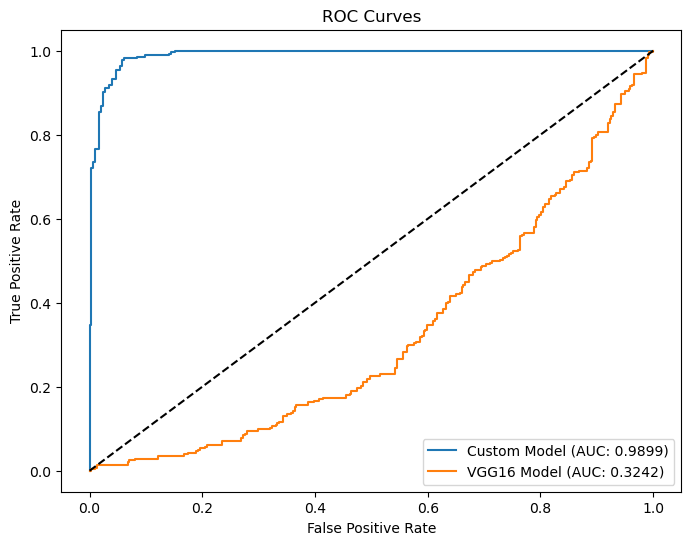

In [77]:
def plot_roc_curve(y_true, y_prob, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC: {roc_auc_score(y_true, y_prob):.4f})")

plt.figure(figsize=(8, 6))
plot_roc_curve(y_test, custom_probs, "Custom Model")
plot_roc_curve(y_test, vgg_probs, "VGG16 Model")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

The plotting of the ROC curves side by side show the balance between sensitivity and specificity within both of our models. For our custom model with an AUC of 0.9936, there is a much higher rate of sensitivity. This means that our custom model is close to reaching perfect discrimination and can distinguish between positive and negative data points. On the other hand, the VGG16 model has an AUC of 0.4628. The score falls very close to 0.5, meaning its performance is not very different from random guessing. A reason that the custom model may outperform the VGG16 model in terms of accuracy could be that our custom model was trained on images of brain scans, whereas the VGG16 model is a more generally-trained model that has been trained on ImageNet with various object images. 

### Confusion Matrix

In [80]:
test_predictions_vgg = np.round(vgg_model.predict(X_test).flatten())

19/19 [==============================] - 86s 5s/step


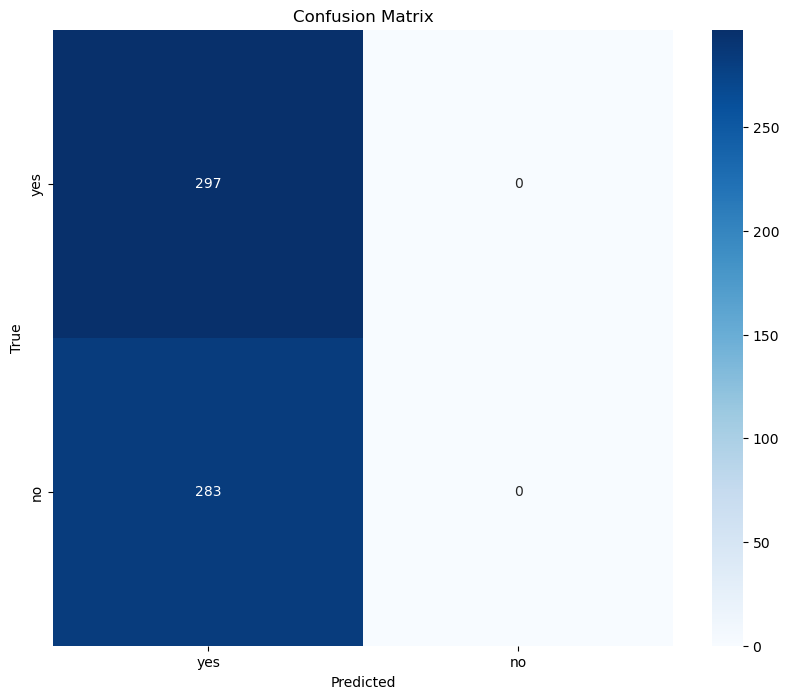

In [83]:
confusion_mat(y_test, test_predictions_vgg, binary_tumor_types)

# Classification Model

# Data Loading

In [85]:
def display_image(image_path):
    img = Image.open(image_path)
    img.show()

giloma_path = './data/classification_data/giloma'
meningioma_path = "./data/classification_data/meningioma"
pituitary_path = "./data/classification_data/pituitary"
no_tumor_path = "./data/classification_data/notumor"

In [86]:
def create_dataframe(giloma_path, meningioma_path, pituitary_path, no_tumor_path):
    # Initialize an empty list to store the data
    data = []

    # Process 'giloma' images
    for image in os.listdir(giloma_path):
        data.append({
            "image_path": os.path.join(giloma_path, image),
            "tumor_type": "giloma"
        })

    # Process 'meningioma' images
    for image in os.listdir(meningioma_path):
        data.append({
            "image_path": os.path.join(meningioma_path, image),
            "tumor_type": "meningioma"
        })
        
    # Process 'pituitary' images
    for image in os.listdir(pituitary_path):
        data.append({
            "image_path": os.path.join(pituitary_path, image),
            "tumor_type": "pituitary"
        })

    # Process 'no tumor' images
    for image in os.listdir(no_tumor_path):
        data.append({
            "image_path": os.path.join(no_tumor_path, image),
            "tumor_type": "no tumor"
        })

    # Create a DataFrame
    df = pd.DataFrame(data)

    return df

# Train, Test, Validation Splits

In [87]:
total_data = create_dataframe(giloma_path, meningioma_path, pituitary_path, no_tumor_path)
total_data = total_data.sample(frac=1).reset_index(drop=True)

In [88]:
# Shuffle and split the data
train_data, val_data, test_data = create_train_test_val_splits(total_data)

# Display the sizes of each set
print(f"Training Set: {len(train_data)}")
print(f"Validation Set: {len(val_data)}")
print(f"Test Set: {len(test_data)}")

print(train_data.head())

Training Set: 4915
Validation Set: 703
Test Set: 1405
                                             image_path  tumor_type
5117  ./data/classification_data/notumor/Tr-no_0760.jpg    no tumor
2727  ./data/classification_data/notumor/Te-no_0080.jpg    no tumor
6133  ./data/classification_data/meningioma/Tr-me_00...  meningioma
908    ./data/classification_data/giloma/Te-gl_0239.jpg      giloma
953   ./data/classification_data/meningioma/Te-me_00...  meningioma


# Make images the same size and normalize

We use the preprocessing code provided by the dataset: 
https://github.com/masoudnick/Brain-Tumor-MRI-Classification/blob/main/Preprocessing.py

In [89]:
# Global counter for images that are excluded
excluded_images_count = 0
all_images = 0

# Using preprocessing code provided with the dataset
def preprocess_image(image_path, image_size=(256,256)):
    global excluded_images_count
    global all_images
    all_images += 1

    try:
        img = cv2.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (3, 3), 0)
        
        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)
        
        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)
        
        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])
        ADD_PIXELS = 0
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        new_img = cv2.resize(new_img, image_size)
        return new_img
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        excluded_images_count += 1
        return None
    
def encode_label(label):
    if label == "giloma":
        return 0
    elif label == "meningioma":
        return 1
    elif label == "pituitary":
        return 2
    else:
        return 3
    
def prepare_dataset(df):
    images = df['image_path'].apply(lambda x: preprocess_image(x)).dropna()
    labels = df['tumor_type'][images.index].apply(encode_label)  # Align labels with images
    return np.array(images.tolist()), np.array(labels)

In [90]:
def show_sample_images(data, preprocess_func, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        img = preprocess_func(data.iloc[i]['image_path'])
        plt.imshow(img)
        plt.title(data.iloc[i]['tumor_type'])
        plt.axis("off")

Total images excluded: 0
all images : 5


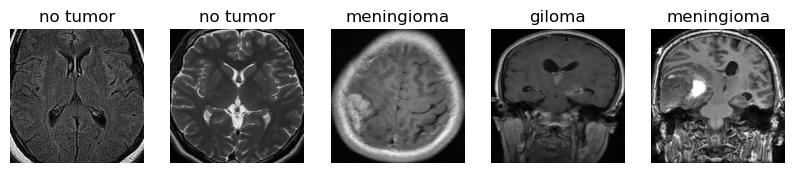

In [91]:
X_train, y_train = transform_dataset(train_data, target_size=(256, 256))
X_val, y_val = transform_dataset(val_data, target_size=(256, 256))
X_test, y_test = transform_dataset(test_data, target_size=(256, 256))

show_sample_images(train_data, preprocess_image)


print(f"Total images excluded: {excluded_images_count}")
print(f"all images : {all_images}")

# Custom Model

In [92]:
num_classes = 4
model_seg = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu, input_shape=(256, 256, 3)),  # Adjusted input shape
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Model Compilation
model_seg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model Training using Validation Data
history_seg = model_seg.fit(X_train, y_train, batch_size=16, epochs=1, verbose=1, validation_data=(X_val, y_val))

308/308 [==============================] - 246s 791ms/step - loss: 1.8873 - accuracy: 0.6210 - val_loss: 0.4450 - val_accuracy: 0.8265


Text(0.5, 1.0, 'Loss over Epochs')

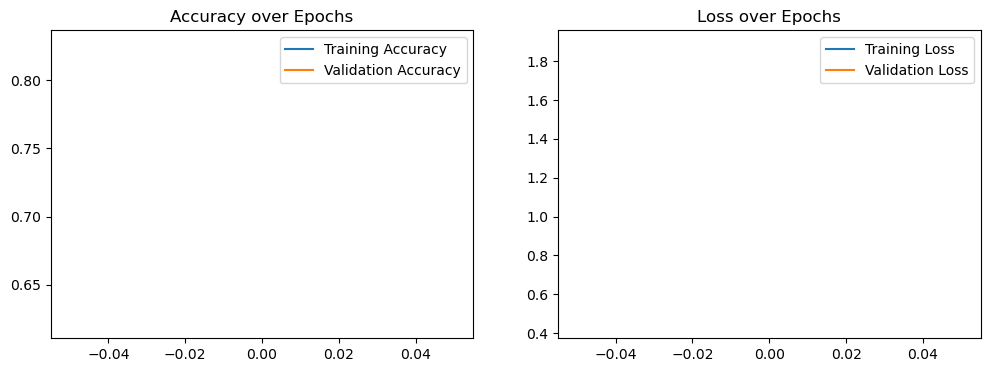

In [93]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_seg.history['accuracy'], label='Training Accuracy')
plt.plot(history_seg.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history_seg.history['loss'], label='Training Loss')
plt.plot(history_seg.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

In [94]:
test_loss, test_accuracy = model_seg.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

44/44 [==============================] - 15s 339ms/step - loss: 0.4485 - accuracy: 0.8228
Test Loss: 0.4485194683074951
Test Accuracy: 0.8227757811546326


### Confusion Matrix

In [96]:
test_predictions_seg = model_seg.predict(X_test)
test_predictions_classes_seg = np.argmax(test_predictions_seg, axis=1)

tumor_types = ['giloma', 'meningioma', 'pituitary', 'no tumor']

44/44 [==============================] - 14s 324ms/step


In [98]:
print(y_test)

[0 2 3 ... 3 0 3]


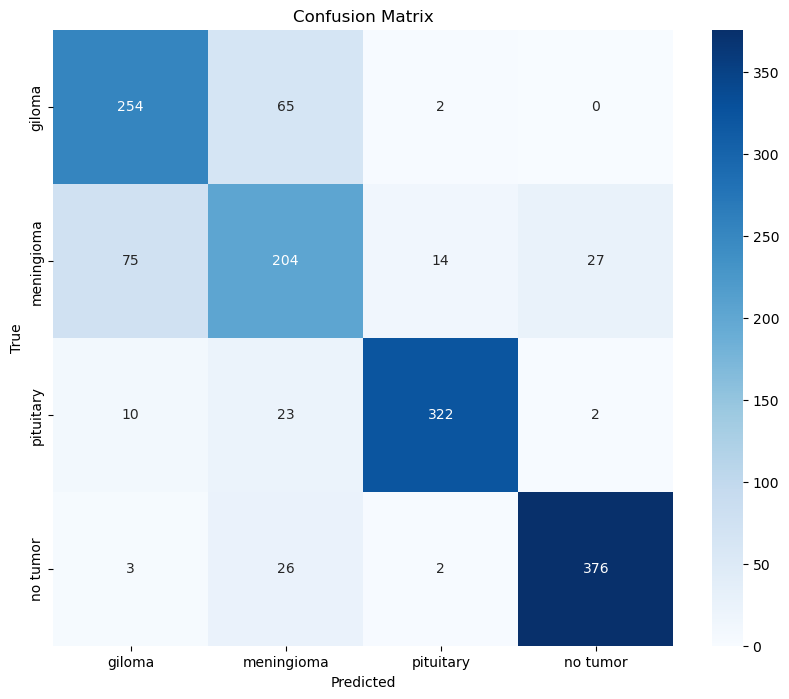

In [99]:
confusion_mat(y_test, test_predictions_classes_seg, tumor_types)

In [100]:
report_seg = classification_report(y_test, test_predictions_classes_seg, target_names=tumor_types)
print(report_seg)

              precision    recall  f1-score   support

      giloma       0.74      0.79      0.77       321
  meningioma       0.64      0.64      0.64       320
   pituitary       0.95      0.90      0.92       357
    no tumor       0.93      0.92      0.93       407

    accuracy                           0.82      1405
   macro avg       0.81      0.81      0.81      1405
weighted avg       0.83      0.82      0.82      1405



## ResNet50 Model

### Train Model

In [26]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model.trainable = False

In [27]:
resnet_model = Sequential([
    resnet_model,  # This is the ResNet50 model instance
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # Example for binary classification
])

In [28]:
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
def preprocess_image_resnet50(image_path, target_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    return preprocess_input(img_array)

In [30]:
def encode_label(label):
    label_mapping = {'giloma': 0, 'meningioma': 1, 'pituitary': 2, 'no tumor': 3}
    return to_categorical(label_mapping[label], num_classes=4)

In [31]:
def transform_dataset(dataframe, target_size=(224, 224)):
    images = []
    labels = []

    for _, row in dataframe.iterrows():
        processed_img = preprocess_image_resnet50(row['image_path'], target_size)
        images.append(processed_img)
        label = encode_label(row['tumor_type'])
        labels.append(label)

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

In [32]:
train_images, train_labels = transform_dataset(train_data)
val_images, val_labels = transform_dataset(val_data)
test_images, test_labels = transform_dataset(test_data)

### Fit and Evaluate Model

In [33]:
# Train the model
history = resnet_model.fit(train_images, train_labels, epochs=5, validation_data=(val_images, val_labels))

# Evaluate the model
test_loss, test_acc = resnet_model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc*100:.2f}%")

Epoch 1/5
  5/154 [..............................] - ETA: 5:53 - loss: 30.3070 - accuracy: 0.3000

KeyboardInterrupt: 

In [ ]:
# Assuming test_images is your test set and resnet_model is your trained model
test_predictions = resnet_model.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(test_labels, axis=1)

### Analyze Results

In [ ]:
# Generate the confusion matrix
cm_res = confusion_matrix(test_true_classes, test_predictions_classes)

# Define the labels of the tumor types
tumor_types = ['giloma', 'meningioma', 'pituitary', 'no tumor']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_res, annot=True, fmt='g', cmap='Blues', xticklabels=tumor_types, yticklabels=tumor_types)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
report_resnet = classification_report(test_true_classes, test_predictions_classes, target_names=tumor_types)
print(report_resnet)

# Using Class Weights

In [35]:
class_weights = { 0: 2.,
                 1: 2.,
                 2: 2.,
                 3: 0.5
                }
# Train the model
history_with_weights = resnet_model.fit(train_images, train_labels, epochs=1, validation_data=(val_images, val_labels), class_weight=class_weights)

# Evaluate the model
test_loss, test_acc = resnet_model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc*100:.2f}%")

44/44 [==============================] - 107s 2s/step - loss: 0.4555 - accuracy: 0.8320
Test Accuracy: 83.20%


In [36]:
test_predictions = resnet_model.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(test_labels, axis=1)

tumor_types = ['giloma', 'meningioma', 'pituitary', 'no tumor']

44/44 [==============================] - 99s 2s/step


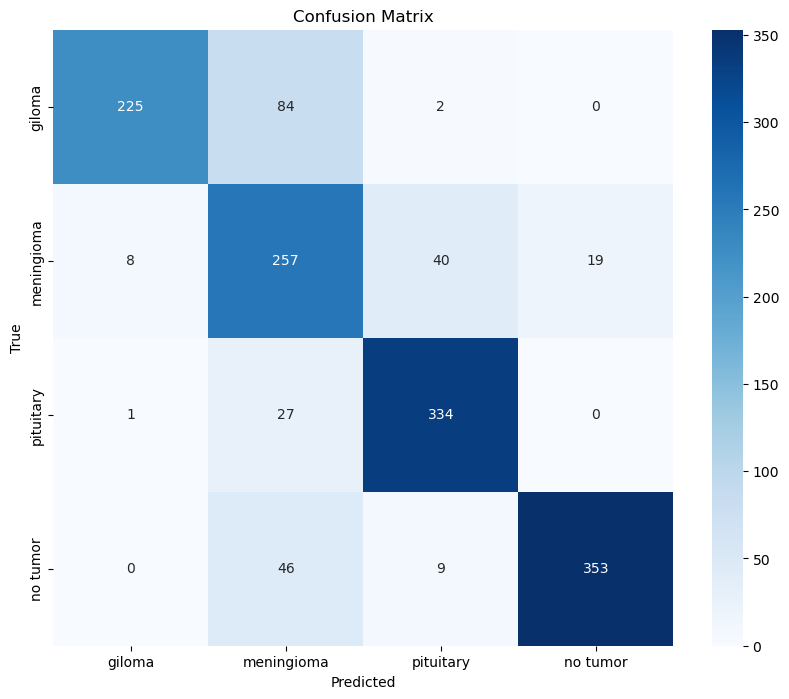

In [41]:
cm_res = confusion_mat(test_true_classes, test_predictions_classes, tumor_types)